# Telecom Provider Churn Prediction
The telecom operator Interconnect would like to be able to forecast their churn of clients. If it's discovered that a user is planning to leave, they will be offered promotional codes and special plan options. Interconnect's marketing team has collected some of their clientele's personal data, including information about their plans and contracts.

## Interconnect's services
Interconnect mainly provides two types of services:

Landline communication. The telephone can be connected to several lines simultaneously.
Internet. The network can be set up via a telephone line (DSL, digital subscriber line) or through a fiber optic cable.
Some other services the company provides include:

Internet security: antivirus software (DeviceProtection) and a malicious website blocker (OnlineSecurity)
A dedicated technical support line (TechSupport)
Cloud file storage and data backup (OnlineBackup)
TV streaming (StreamingTV) and a movie directory (StreamingMovies)
The clients can choose either a monthly payment or sign a 1- or 2-year contract. They can use various payment methods and receive an electronic invoice after a transaction.

Let's dive right in

## Steps We Will Follow:

1. Load the Data and Inspect individual datasets
2. Scrub Missing values from individual datasets
3. Remove Outliers(if any)
4. Convert Datatypes.
5. Combine the datasets with an outer join to ensure no values are dropped
6. Feature Engineering: Select features to utilise, create new features that will assist the model
7. Split dataset into train and test data
8. Build a baseline model for sanity checks
9. Build models for prediction
10. Test most suitable model and calculate AUC ROC Score
11. Report findings

## Qualifying Questions

1. Do users with longer contracts have lower likelihood of churn? 
2. Is the duration of relationship with a customer to be an indicator of loyalty?
3. Do automatic payment methods imply less likelihood of churn?

In [1]:
#Start with some magic
%matplotlib inline

In [2]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

In [3]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [4]:
#Initialize some variables for repeatability
random_state = 12345

In [5]:
#Load the data
datasets = ['contract','internet','personal','phone']
dfs = []
for dataset in datasets:
    temp_df = pd.read_csv('yandex/final_provider/'+dataset+'.csv')
    dfs.append(temp_df)

In [6]:
#Take a peek at the info
for df,dataset in zip(dfs,datasets):
    print(f'Information on {dataset} dataset')
    print('-' * 50)
    df.info()
    print()

Information on contract dataset
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB

Information on internet dataset
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   

In [7]:
for df,dataset in zip(dfs,datasets):
    print(f'Shape of {dataset} dataset')
    print('-' * 25)
    print(df.shape)
    print()

Shape of contract dataset
-------------------------
(7043, 8)

Shape of internet dataset
-------------------------
(5517, 8)

Shape of personal dataset
-------------------------
(7043, 5)

Shape of phone dataset
-------------------------
(6361, 2)



In [8]:
#Fix column names
for df in dfs:
    df.columns = df.columns.str.lower()

In [9]:
contract, internet, personal, phone = dfs[0], dfs[1], dfs[2], dfs[3]

### The Data

We loaded 4 datasets. There are 7,043 customers. Some customers do not use phone and some do not use the internet. We will now inspect the datasets individually.

#### Contracts

In [10]:
contract.describe()

,monthlycharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


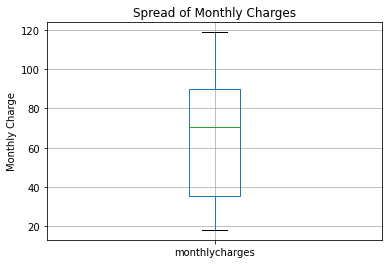

In [11]:
contract.boxplot()
plt.title('Spread of Monthly Charges')
plt.ylabel('Monthly Charge');

No outliers here

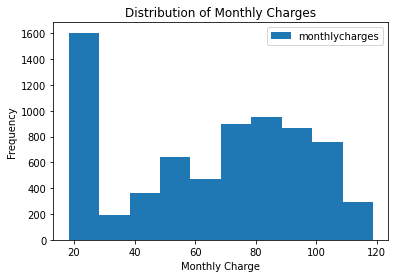

In [12]:
contract.plot(kind='hist')
plt.title('Distribution of Monthly Charges')
plt.xlabel('Monthly Charge');

In [13]:
#Inspecting the columns
contract.columns

Index(['customerid', 'begindate', 'enddate', 'type', 'paperlessbilling',
       'paymentmethod', 'monthlycharges', 'totalcharges'],
      dtype='object')

In [14]:
#Convert the totalcharges column to numeric type. 
contract['totalcharges'] = pd.to_numeric(contract['totalcharges'],errors = 'coerce')

In [15]:
contract['totalcharges'].isna().sum()

11

We have a few missing values created as a result of our conversion. Looks like these values were blanks. Let's fill them in using a median for the column. As there are just 11 values, we don't expect a large effect.

In [16]:
contract['totalcharges'].fillna(contract['totalcharges'].median(), inplace = True)

In [17]:
contract['totalcharges'].isna().sum()

0

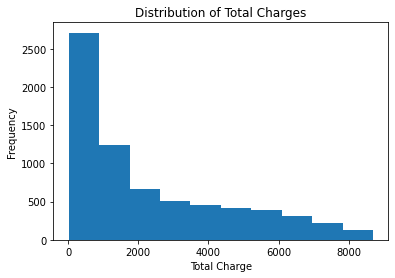

In [18]:
contract['totalcharges'].plot(kind='hist')
plt.title('Distribution of Total Charges')
plt.xlabel('Total Charge');

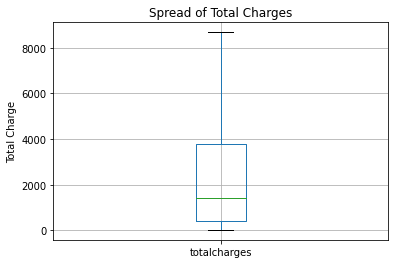

In [19]:
contract.boxplot(column = 'totalcharges')
plt.title('Spread of Total Charges')
plt.ylabel('Total Charge');

No outliers here. 

In [20]:
contract['type'].value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: type, dtype: int64

In [21]:
contract['paymentmethod'].value_counts()

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: paymentmethod, dtype: int64

We can reduce dimensionality and change the value to automatic and manual

In [22]:
automatic = ['Bank transfer (automatic)','Credit card (automatic)']

In [23]:
contract['paymentmethod'][contract['paymentmethod'].isin(automatic)] = 'automatic'

/var/folders/91/lmb79xzd7v7b3dp6_n9djnfh0000gn/T/ipykernel_38122/540856575.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  contract['paymentmethod'][contract['paymentmethod'].isin(automatic)] = 'automatic'


In [24]:
contract['paymentmethod'][contract['paymentmethod'] != 'automatic'] = 'manual'

/var/folders/91/lmb79xzd7v7b3dp6_n9djnfh0000gn/T/ipykernel_38122/1600310655.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  contract['paymentmethod'][contract['paymentmethod'] != 'automatic'] = 'manual'


In [25]:
contract['paymentmethod'].value_counts()

manual       3977
automatic    3066
Name: paymentmethod, dtype: int64

In [26]:
contract['paperlessbilling'].value_counts()

Yes    4171
No     2872
Name: paperlessbilling, dtype: int64

In [27]:
contract['enddate'].value_counts()

No                     5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: enddate, dtype: int64

For all instances where the `enddate` is **No**, we assume that the user has not churned.

We will create a new churn column as our target variable

In [28]:
contract['churn'] = 1

In [29]:
contract['churn'][contract['enddate'] == 'No'] = 0

/var/folders/91/lmb79xzd7v7b3dp6_n9djnfh0000gn/T/ipykernel_38122/1956919321.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  contract['churn'][contract['enddate'] == 'No'] = 0


In [30]:
contract['churn'].value_counts()

0    5174
1    1869
Name: churn, dtype: int64

Perfect. No other obvious issues with the data. Let's set the `customerid` as index and move on to the next dataset.

In [31]:
contract = contract.set_index('customerid')

#### Internet

In [32]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerid        5517 non-null   object
 1   internetservice   5517 non-null   object
 2   onlinesecurity    5517 non-null   object
 3   onlinebackup      5517 non-null   object
 4   deviceprotection  5517 non-null   object
 5   techsupport       5517 non-null   object
 6   streamingtv       5517 non-null   object
 7   streamingmovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [33]:
internet.head()

,customerid,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [34]:
internet.isna().sum()

customerid          0
internetservice     0
onlinesecurity      0
onlinebackup        0
deviceprotection    0
techsupport         0
streamingtv         0
streamingmovies     0
dtype: int64

No NaN values. We can replace No and Yes with a one-hot encoding for all columns later when we prepare the data.

In [35]:
internet = internet.set_index('customerid')

#### Personal

In [36]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerid     7043 non-null   object
 1   gender         7043 non-null   object
 2   seniorcitizen  7043 non-null   int64 
 3   partner        7043 non-null   object
 4   dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [37]:
personal.head()

,customerid,gender,seniorcitizen,partner,dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [38]:
personal.isna().sum()

customerid       0
gender           0
seniorcitizen    0
partner          0
dependents       0
dtype: int64

No missing values. Once again, we can one-hot encode categorical values when we prepare the data.

In [39]:
personal = personal.set_index('customerid')

#### Phone

In [40]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerid     6361 non-null   object
 1   multiplelines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [41]:
phone.head()

,customerid,multiplelines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [42]:
phone.isna().sum()

customerid       0
multiplelines    0
dtype: int64

No missing values, we can encode the `multiplelines` variable as we prepare the datasets.

In [43]:
phone = phone.set_index('customerid')

### Preparing the Data

To prepare the data, let's combine the data frame with an **outer join** to ensure we do not lose any information. 

In [44]:
dfs = [internet,personal,phone]
df = contract
for df_ in dfs:
    df = df.join(df_, how = 'outer')

In [45]:
print(f'Shape of combined dataframe:{df.shape}')

Shape of combined dataframe:(7043, 20)


The join has yielded 7,043 rows and 20 columns. Let's clean up missing values.

In [46]:
df.isna().sum()

begindate              0
enddate                0
type                   0
paperlessbilling       0
paymentmethod          0
monthlycharges         0
totalcharges           0
churn                  0
internetservice     1526
onlinesecurity      1526
onlinebackup        1526
deviceprotection    1526
techsupport         1526
streamingtv         1526
streamingmovies     1526
gender                 0
seniorcitizen          0
partner                0
dependents             0
multiplelines        682
dtype: int64

In [47]:
internet.columns

Index(['internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection',
       'techsupport', 'streamingtv', 'streamingmovies'],
      dtype='object')

In [48]:
df.loc[df['internetservice'].isna(),internet.columns] = 'No'

In [49]:
df.loc[df['multiplelines'].isna(),'multiplelines'] = 'No'

In [50]:
df.isna().sum()

begindate           0
enddate             0
type                0
paperlessbilling    0
paymentmethod       0
monthlycharges      0
totalcharges        0
churn               0
internetservice     0
onlinesecurity      0
onlinebackup        0
deviceprotection    0
techsupport         0
streamingtv         0
streamingmovies     0
gender              0
seniorcitizen       0
partner             0
dependents          0
multiplelines       0
dtype: int64

We filled the missing values with 'No' as we assume that a missing `customerid` from the internet or phone database indicates that the customer does not use this service.

Next, will create some features while dropping unnecessary ones to make the model robust.

We start by adding an `age` column for the age of the customer. A higher age is likely to indicate more loyalty. 

In [51]:
df['begindate'] = pd.to_datetime(df['begindate'], format = '%Y-%m-%d')

In [52]:
last_date = dt.datetime(2020,2,1) 

<div class="alert alert-success">
<b>Reviewer's comment</b>

Great, the last date is correct
    
</div>

In [53]:
df['age_days'] = last_date - df['begindate']

In [54]:
df['age_days'] = df['age_days'].dt.days

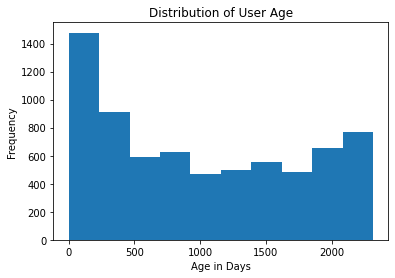

In [55]:
df['age_days'].plot(kind='hist')
plt.title('Distribution of User Age')
plt.xlabel('Age in Days');

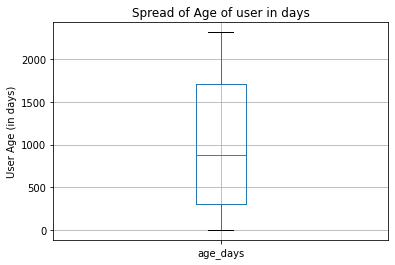

In [56]:
df.boxplot('age_days')
plt.title('Spread of Age of user in days')
plt.ylabel('User Age (in days)');

No outliers in the age column. The spread is quite wide. 

Let's convert all 'No' values to 0 and 'Yes' values to 1 to make these features numeric. Looking at the features, we can assume that a 'Yes' is better for customer loyalty as they are utilising more services. We don't have a very clear idea of the effects of
1. Paperless billing 
2. Billing method

We will study this correlation later.

In [57]:
df.replace(to_replace=['Yes','No'], value = [1,0],inplace = True)

Let's drop the following columns as we have extracted meaningful value from them: 
1. `begindate`
2. `enddate`

In [58]:
df = df.drop(columns = ['begindate','enddate'])

In [59]:
df.head()

,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,gender,seniorcitizen,partner,dependents,multiplelines,age_days
customerid,,,,,,,,,,,,,,,,,,,
0002-ORFBO,One year,1,manual,65.6,593.30,0,DSL,0,1,0,1,1,0,Female,0,1,1,0,276
0003-MKNFE,Month-to-month,0,manual,59.9,542.40,0,DSL,0,0,0,0,0,1,Male,0,0,0,1,276
0004-TLHLJ,Month-to-month,1,manual,73.9,280.85,1,Fiber optic,0,0,1,0,0,0,Male,0,0,0,0,153
0011-IGKFF,Month-to-month,1,manual,98.0,1237.85,1,Fiber optic,0,1,1,0,1,1,Male,1,1,0,0,427
0013-EXCHZ,Month-to-month,1,manual,83.9,267.40,1,Fiber optic,0,0,0,1,1,0,Female,1,1,0,0,153


Let's look at correlations of features with the churn to identify the top features we will consider

In [60]:
df.corr()['churn'].sort_values(ascending = False)

churn               1.000000
monthlycharges      0.193356
paperlessbilling    0.191825
seniorcitizen       0.150889
streamingtv         0.063228
streamingmovies     0.061382
multiplelines       0.040102
deviceprotection   -0.066160
onlinebackup       -0.082255
partner            -0.150448
dependents         -0.164221
techsupport        -0.164674
onlinesecurity     -0.171226
totalcharges       -0.199037
age_days           -0.311715
Name: churn, dtype: float64

Let's reduce dimensionality by combining some features:
1. `streamingtv` and `streamingmovies` into one feature `streaming`. This will be a logical OR of the two. 
2.`partner` and `dependents` into one feature - `family`. This will be a logical OR of the two. 

In [61]:
df['streaming'] = df['streamingtv'] | df['streamingmovies']

In [62]:
df['family'] = df['partner'] | df['dependents']

In [63]:
df.corr()['churn'].sort_values(ascending = False)

churn               1.000000
monthlycharges      0.193356
paperlessbilling    0.191825
seniorcitizen       0.150889
streaming           0.085200
streamingtv         0.063228
streamingmovies     0.061382
multiplelines       0.040102
deviceprotection   -0.066160
onlinebackup       -0.082255
partner            -0.150448
family             -0.162835
dependents         -0.164221
techsupport        -0.164674
onlinesecurity     -0.171226
totalcharges       -0.199037
age_days           -0.311715
Name: churn, dtype: float64

Dropping features that we will not use:

In [64]:
df.drop(columns = ['streamingtv','streamingmovies','partner','dependents'],inplace = True)

In [65]:
df.corr()['churn'].sort_values(ascending = False)

churn               1.000000
monthlycharges      0.193356
paperlessbilling    0.191825
seniorcitizen       0.150889
streaming           0.085200
multiplelines       0.040102
deviceprotection   -0.066160
onlinebackup       -0.082255
family             -0.162835
techsupport        -0.164674
onlinesecurity     -0.171226
totalcharges       -0.199037
age_days           -0.311715
Name: churn, dtype: float64

Great! We have our features now. Next we will:

1. Encode the categorical features
2. Standardize numerical features

In [66]:
df.dtypes

type                 object
paperlessbilling      int64
paymentmethod        object
monthlycharges      float64
totalcharges        float64
churn                 int64
internetservice      object
onlinesecurity        int64
onlinebackup          int64
deviceprotection      int64
techsupport           int64
gender               object
seniorcitizen         int64
multiplelines         int64
age_days              int64
streaming             int64
family                int64
dtype: object

In [67]:
categorical = ['paymentmethod','gender','internetservice']

We will assume that longer contract lengths imply reduced risk of churn. For all others, we will one-hot encode.

In [68]:
df = pd.get_dummies(df,columns = categorical, drop_first = True)

In [69]:
df['type'].value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: type, dtype: int64

In [70]:
df.loc[df['type']=='Month-to-month','type'] = 1
df.loc[df['type']=='One year','type'] = 2
df.loc[df['type']=='Two year','type'] = 3

To standardize values, let's look at the distributions to help us choose the best scaling methodology.

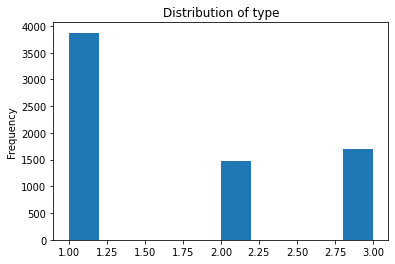

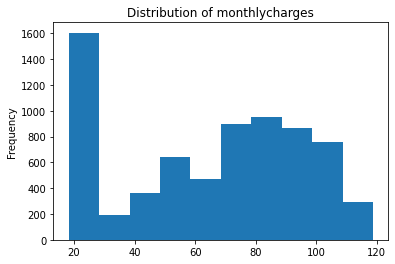

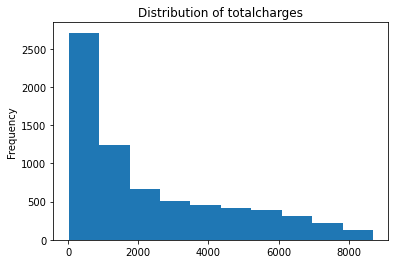

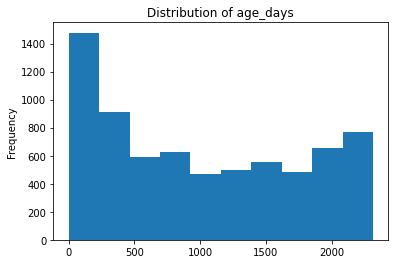

In [71]:
dist_columns = ['type','monthlycharges','totalcharges','age_days']

for col_ in dist_columns:
    plt.figure()
    df[col_].plot(kind='hist')
    plt.title(f'Distribution of {col_}');

In [72]:
from sklearn.preprocessing import MinMaxScaler

In [73]:
scaler = MinMaxScaler()

In [74]:
corr_df = df.corr()['churn'].sort_values(ascending = False) 

In [75]:
columns_to_drop = list(corr_df[(corr_df < 0.1) & (corr_df > - 0.1)].index)

We notice very low correlation between churn and the following columns:
1. `streaming`
2. `multiplelines`
3. `gender_Male`
4. `deviceprotection`
5. `onlinebackup`

It makes sense to drop these columns to reduce dimensionality and overfitting.

In [76]:
df = df.drop(columns = columns_to_drop)

Great, the data is now prepared. The next step is to split the data. We will carry out a couple of checks to decide the best procdure for sampling

In [77]:
df['churn'].value_counts(normalize = True)

0    0.73463
1    0.26537
Name: churn, dtype: float64

In [78]:
from sklearn.utils import shuffle

In [79]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345
    )

    return features_upsampled, target_upsampled

We'll carry out a simple split using `train_test_split`.

In [80]:
from sklearn.model_selection import train_test_split


In [81]:
df_train, df_test = train_test_split(df, random_state = random_state, test_size = 0.2)

In [82]:
scaler.fit(df_train)
df_train_scaled = pd.DataFrame(data = scaler.transform(df_train), index = df_train.index, 
                                           columns = df_train.columns)
df_test_scaled = pd.DataFrame(data = scaler.transform(df_test), index = df_test.index, 
                                           columns = df_test.columns)

In [83]:
X_train = df_train.drop('churn', axis = 1)
y_train = df_train['churn']

In [84]:
X_train, y_train = upsample(X_train, y_train, 3)

In [85]:
y_train.value_counts(normalize = True)

1    0.523232
0    0.476768
Name: churn, dtype: float64

In [86]:
X_test = df_test.drop('churn', axis = 1)
y_test = df_test['churn']

## Model Selection

In the next step, we will use the prepared data to train a baseline model - the Dummy Classifier. Then, we will check various other models to finally obtain a suitable one.

In [87]:
from sklearn.dummy import DummyClassifier

In [88]:
from sklearn.metrics import roc_auc_score

In [89]:
dummy_model = DummyClassifier(random_state = random_state)

In [90]:
dummy_model.fit(X_train,y_train)

DummyClassifier(random_state=12345)

In [91]:
def score(model,data,targets,model_name):
    probabilities_valid = model.predict_proba(data)
    probabilities_one_valid = probabilities_valid[:, 1]
    roc_auc = roc_auc_score(targets,probabilities_one_valid)
    print(f'ROC-AUC Score for {model_name} is: {roc_auc:.4f}')

In [92]:
score(dummy_model,X_train,y_train, 'Dummy Model')

ROC-AUC Score for Dummy Model is: 0.5000


Great! Sanity check shows a ROC AUC Score of 0.5. Let's try some models.

#### Logistic Regression

In [93]:
from sklearn.linear_model import LogisticRegression

In [94]:
logistic_model = LogisticRegression()

In [95]:
logistic_model.fit(X_train,y_train)

LogisticRegression()

In [96]:
score(logistic_model,X_train,y_train, 'Logistic Regression')

ROC-AUC Score for Logistic Regression is: 0.8323


Let's try something more complicated

In [97]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [98]:
params_grid = {'n_estimators':[100,150,200], 'max_depth' : [15,20,25,30]}

In [99]:
gcv = GridSearchCV(estimator = RandomForestClassifier(), param_grid = params_grid, cv = 3)

In [100]:
gcv.fit(X_train,y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [15, 20, 25, 30],
                         'n_estimators': [100, 150, 200]})

In [101]:
gcv.best_params_

{'max_depth': 30, 'n_estimators': 150}

In [102]:
score(gcv,X_train,y_train, 'Random Forest Classifier')

ROC-AUC Score for Random Forest Classifier is: 1.0000


Clearly, the random forest overfits to our rather small training set. Let's try catboost.

In [103]:
from catboost import CatBoostClassifier

In [104]:
catb = CatBoostClassifier()

In [105]:
catb.fit(X_train,y_train)

Learning rate set to 0.025887
0:	learn: 0.6779699	total: 65.6ms	remaining: 1m 5s
1:	learn: 0.6656203	total: 67.7ms	remaining: 33.8s
2:	learn: 0.6539115	total: 69.7ms	remaining: 23.2s
3:	learn: 0.6436416	total: 71.5ms	remaining: 17.8s
4:	learn: 0.6342881	total: 73.1ms	remaining: 14.5s
5:	learn: 0.6252619	total: 74.9ms	remaining: 12.4s
6:	learn: 0.6168097	total: 76.8ms	remaining: 10.9s
7:	learn: 0.6066880	total: 78.4ms	remaining: 9.72s
8:	learn: 0.5993009	total: 80.5ms	remaining: 8.87s
9:	learn: 0.5919604	total: 82.9ms	remaining: 8.21s
10:	learn: 0.5850124	total: 85.1ms	remaining: 7.65s
11:	learn: 0.5775767	total: 87.3ms	remaining: 7.18s
12:	learn: 0.5700758	total: 89.6ms	remaining: 6.8s
13:	learn: 0.5630104	total: 91.8ms	remaining: 6.47s
14:	learn: 0.5569625	total: 93.7ms	remaining: 6.15s
15:	learn: 0.5524182	total: 96.2ms	remaining: 5.92s
16:	learn: 0.5478308	total: 98.4ms	remaining: 5.69s
17:	learn: 0.5432255	total: 100ms	remaining: 5.48s
18:	learn: 0.5368963	total: 103ms	remaining: 5

174:	learn: 0.3842556	total: 461ms	remaining: 2.17s
175:	learn: 0.3836356	total: 463ms	remaining: 2.17s
176:	learn: 0.3833398	total: 465ms	remaining: 2.16s
177:	learn: 0.3827603	total: 467ms	remaining: 2.15s
178:	learn: 0.3824412	total: 469ms	remaining: 2.15s
179:	learn: 0.3821746	total: 472ms	remaining: 2.15s
180:	learn: 0.3819167	total: 474ms	remaining: 2.15s
181:	learn: 0.3815749	total: 476ms	remaining: 2.14s
182:	learn: 0.3810808	total: 478ms	remaining: 2.13s
183:	learn: 0.3808213	total: 481ms	remaining: 2.13s
184:	learn: 0.3806396	total: 483ms	remaining: 2.13s
185:	learn: 0.3800304	total: 485ms	remaining: 2.12s
186:	learn: 0.3797068	total: 487ms	remaining: 2.12s
187:	learn: 0.3793766	total: 490ms	remaining: 2.11s
188:	learn: 0.3791672	total: 492ms	remaining: 2.11s
189:	learn: 0.3787117	total: 494ms	remaining: 2.1s
190:	learn: 0.3785036	total: 496ms	remaining: 2.1s
191:	learn: 0.3778722	total: 499ms	remaining: 2.1s
192:	learn: 0.3774384	total: 501ms	remaining: 2.1s
193:	learn: 0.37

345:	learn: 0.3297382	total: 856ms	remaining: 1.62s
346:	learn: 0.3294741	total: 859ms	remaining: 1.62s
347:	learn: 0.3291955	total: 861ms	remaining: 1.61s
348:	learn: 0.3288861	total: 864ms	remaining: 1.61s
349:	learn: 0.3286143	total: 866ms	remaining: 1.61s
350:	learn: 0.3282841	total: 869ms	remaining: 1.6s
351:	learn: 0.3279732	total: 871ms	remaining: 1.6s
352:	learn: 0.3277141	total: 873ms	remaining: 1.6s
353:	learn: 0.3274990	total: 875ms	remaining: 1.6s
354:	learn: 0.3273068	total: 877ms	remaining: 1.59s
355:	learn: 0.3269966	total: 880ms	remaining: 1.59s
356:	learn: 0.3268070	total: 882ms	remaining: 1.59s
357:	learn: 0.3265932	total: 885ms	remaining: 1.59s
358:	learn: 0.3262281	total: 887ms	remaining: 1.58s
359:	learn: 0.3259489	total: 890ms	remaining: 1.58s
360:	learn: 0.3257303	total: 893ms	remaining: 1.58s
361:	learn: 0.3254181	total: 895ms	remaining: 1.58s
362:	learn: 0.3250737	total: 897ms	remaining: 1.57s
363:	learn: 0.3247988	total: 899ms	remaining: 1.57s
364:	learn: 0.32

513:	learn: 0.2827723	total: 1.25s	remaining: 1.18s
514:	learn: 0.2825573	total: 1.25s	remaining: 1.18s
515:	learn: 0.2823949	total: 1.26s	remaining: 1.18s
516:	learn: 0.2822451	total: 1.26s	remaining: 1.18s
517:	learn: 0.2820867	total: 1.26s	remaining: 1.17s
518:	learn: 0.2818950	total: 1.26s	remaining: 1.17s
519:	learn: 0.2817484	total: 1.27s	remaining: 1.17s
520:	learn: 0.2814634	total: 1.27s	remaining: 1.17s
521:	learn: 0.2811274	total: 1.27s	remaining: 1.16s
522:	learn: 0.2809074	total: 1.27s	remaining: 1.16s
523:	learn: 0.2806447	total: 1.28s	remaining: 1.16s
524:	learn: 0.2804253	total: 1.28s	remaining: 1.16s
525:	learn: 0.2802262	total: 1.28s	remaining: 1.15s
526:	learn: 0.2800389	total: 1.28s	remaining: 1.15s
527:	learn: 0.2797817	total: 1.28s	remaining: 1.15s
528:	learn: 0.2795368	total: 1.29s	remaining: 1.15s
529:	learn: 0.2793614	total: 1.29s	remaining: 1.14s
530:	learn: 0.2791282	total: 1.29s	remaining: 1.14s
531:	learn: 0.2788587	total: 1.29s	remaining: 1.14s
532:	learn: 

688:	learn: 0.2470904	total: 1.65s	remaining: 744ms
689:	learn: 0.2469747	total: 1.65s	remaining: 741ms
690:	learn: 0.2467682	total: 1.65s	remaining: 739ms
691:	learn: 0.2466157	total: 1.65s	remaining: 737ms
692:	learn: 0.2463366	total: 1.66s	remaining: 734ms
693:	learn: 0.2461006	total: 1.66s	remaining: 732ms
694:	learn: 0.2459933	total: 1.66s	remaining: 729ms
695:	learn: 0.2458174	total: 1.66s	remaining: 726ms
696:	learn: 0.2456511	total: 1.67s	remaining: 724ms
697:	learn: 0.2455267	total: 1.67s	remaining: 721ms
698:	learn: 0.2453190	total: 1.67s	remaining: 719ms
699:	learn: 0.2450867	total: 1.67s	remaining: 717ms
700:	learn: 0.2448548	total: 1.67s	remaining: 714ms
701:	learn: 0.2447595	total: 1.68s	remaining: 712ms
702:	learn: 0.2446283	total: 1.68s	remaining: 709ms
703:	learn: 0.2445416	total: 1.68s	remaining: 707ms
704:	learn: 0.2443718	total: 1.68s	remaining: 705ms
705:	learn: 0.2442693	total: 1.69s	remaining: 702ms
706:	learn: 0.2441718	total: 1.69s	remaining: 700ms
707:	learn: 

862:	learn: 0.2190163	total: 2.04s	remaining: 325ms
863:	learn: 0.2188783	total: 2.05s	remaining: 322ms
864:	learn: 0.2187475	total: 2.05s	remaining: 320ms
865:	learn: 0.2186078	total: 2.05s	remaining: 318ms
866:	learn: 0.2184522	total: 2.06s	remaining: 315ms
867:	learn: 0.2182724	total: 2.06s	remaining: 313ms
868:	learn: 0.2181119	total: 2.06s	remaining: 311ms
869:	learn: 0.2179620	total: 2.06s	remaining: 308ms
870:	learn: 0.2178188	total: 2.06s	remaining: 306ms
871:	learn: 0.2176526	total: 2.07s	remaining: 304ms
872:	learn: 0.2174744	total: 2.07s	remaining: 301ms
873:	learn: 0.2173423	total: 2.07s	remaining: 299ms
874:	learn: 0.2172535	total: 2.08s	remaining: 296ms
875:	learn: 0.2171157	total: 2.08s	remaining: 294ms
876:	learn: 0.2169725	total: 2.08s	remaining: 292ms
877:	learn: 0.2168421	total: 2.08s	remaining: 289ms
878:	learn: 0.2166960	total: 2.08s	remaining: 287ms
879:	learn: 0.2165542	total: 2.09s	remaining: 285ms
880:	learn: 0.2164167	total: 2.09s	remaining: 282ms
881:	learn: 

In [106]:
score(catb,X_train,y_train,'Cat Boost')

ROC-AUC Score for Cat Boost is: 0.9893


In [107]:
param_grid = {
        'learning_rate': [0.1, 0.4],
        'depth': [3,6],
        'l2_leaf_reg': [5, 7, 9],
        'iterations':[80,85],
        'thread_count':[12],
        'border_count':[128]
}

In [108]:
cb = CatBoostClassifier(loss_function = 'Logloss', random_seed = random_state, eval_metric = 'AUC', verbose = 0)

In [109]:
gcv = GridSearchCV(cb, param_grid = param_grid,cv = 3)

In [110]:
gcv.fit(X_train,y_train)

TBB Warning: The number of workers is currently limited to 7. The request for 11 workers is ignored. Further requests for more workers will be silently ignored until the limit changes.



GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x7ff2901f37c0>,
             param_grid={'border_count': [128], 'depth': [3, 6],
                         'iterations': [80, 85], 'l2_leaf_reg': [5, 7, 9],
                         'learning_rate': [0.1, 0.4], 'thread_count': [12]})

In [111]:
gcv.best_params_

{'border_count': 128,
 'depth': 6,
 'iterations': 85,
 'l2_leaf_reg': 5,
 'learning_rate': 0.4,
 'thread_count': 12}

In [112]:
score(gcv,X_test,y_test,'CatBoost with Best Params')

ROC-AUC Score for CatBoost with Best Params is: 0.9355


In [113]:
from sklearn.metrics import roc_curve

In [114]:
probabilities_test = gcv.predict_proba(X_test)
probabilities_one_valid = probabilities_test[:, 1]

fpr, tpr, thresholds = roc_curve(y_test,probabilities_one_valid)

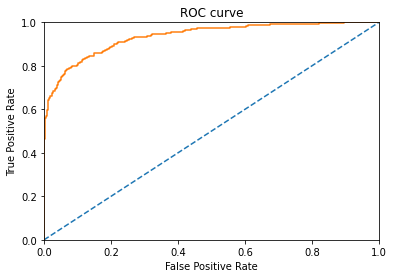

In [115]:
plt.figure()




plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr,tpr)
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.title("ROC curve")

plt.show()

We obtain a best AUC-ROC of 0.94 with a CatBoost model.

## Report

### Challenges Encountered
1. The biggest challenge was the high dimensionality of the data and the relatively small sample size which required feature engineering to solve. Features were dropped based on correlation and feature importance.

### Key Steps
1. Inspecting the data
2. Eliminating missing values
3. Converting datatypes
4. Combining datasets
5. Encoding categorical variables
6. Scaling and upsampling the dataset
7. Defining a scoring metric
8. Testing Multiple models and choosing the best performing model
9. Using Grid Search to identify best parameters for the model
10. Testing the model

### Final Model
1. The model chosen is a CatBoost Classifier with AUC ROC score of **0.94** on the test dataset.